In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import paths
import legwork as lw
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
import utils
import tqdm
from schwimmbad import MultiPool

In [2]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 12

# update various fontsizes to match
params = {'figure.figsize': (14, 3),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)


### First, let's load in the LIGO rate from utils

In [71]:
m1, q, M1, Q, dN_dm1dqdVcdt = utils.get_LIGO_rate(down_samp_fac=50)

In [72]:
dm1 = np.mean(m1[1:] - m1[:-1])
dq = np.mean(q[1:] - q[:-1])

In [73]:
dm1, dq

(<Quantity 4.9049049 solMass>, 0.09018036072144289)

In [6]:
MC=utils.chirp_mass(m1=M1, m2=M1*Q)


Text(0.5, 0, 'chirp mass [$M_{\\odot}$]')

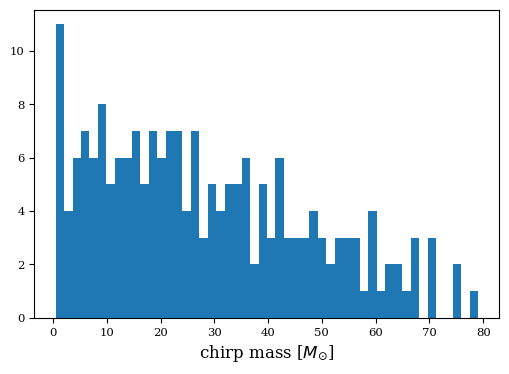

In [7]:
fig = plt.figure(figsize=(6,4))
plt.hist(MC.flatten(), bins=50);
plt.xlabel(r'chirp mass [$M_{\odot}$]')

### Ok -- so this is a rate per m1 per q per comoving volume per year. In order to map this to the future population of BBH mergers that are currently in the LISA band, we will make a few assumptions:

#### 1) this merger rate is constant across the LISA horizon volume
#### 2) the rate will be constant until the lowest frequency LISA source today merges in the future

### Let's check how realistic these assumptions are by looking at the maximum horizon volume as a function of chirp mass and eccnetricity and the maximum merger time for sources in the LISA band as a function of chirp mass and eccentrcitiy

In [8]:
ecc_LIGO_grid = np.logspace(-7, -3, 5)
ecc_LIGO_grid = np.append(0.0, ecc_LIGO_grid)
f_LISA_grid = np.logspace(-4, -1, 50)*u.Hz

MM, QQ, EE_LIGO, FF = np.meshgrid(m1, q, ecc_LIGO_grid, f_LISA_grid)

print(f"The size of our dataset is {len(MM.flatten())} binaries")

The size of our dataset is 60000 binaries


In [16]:
dat_in = list(zip(EE_LIGO.flatten(), FF.flatten(), MM.flatten(), QQ.flatten()*MM.flatten()))

with MultiPool(processes=128) as pool:
    dat_out = list(tqdm.tqdm(pool.imap(utils.get_e_LISA_t_LIGO, dat_in), total=len(dat_in)))
    
EE_LISA, TT_LIGO = zip(*dat_out)




100%|██████████| 60000/60000 [00:28<00:00, 2134.52it/s]


In [17]:
EE_LISA = np.array(EE_LISA).reshape(FF.shape)
TT_LIGO = np.array(TT_LIGO).reshape(FF.shape) * u.yr

In [9]:
#np.save('e_LISA_grid', EE_LISA)
#np.save('T_merge_grid', TT_LIGO.value)
#

EE_LISA = np.load('e_LISA_grid.npy')
TT_LIGO = np.load('T_merge_grid.npy')*u.yr

In [19]:
#plt.plot(ecc_LIGO_grid, TT_LIGO[0, 0, :, 0].value, label=f'm1={m1_grid[0]}, q={q_grid[0]}')
#plt.plot(ecc_LIGO_grid, TT_LIGO[4, 9, :, 0].value, label=f'm1={m1_grid[14]}, q={q_grid[4]}')
#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
#plt.ylabel(r'$T_{\rm{merge}}$ from f=1e-4 Hz [yr]')
#plt.xlabel('eccentricity in LISA')

In [20]:
snr_thresh = 12
dat_in = list(zip(MM.flatten(), QQ.flatten(), EE_LISA.flatten(), FF.flatten(), snr_thresh * np.ones(len(MM.flatten()))))
with MultiPool(processes=128) as pool:
    dat_out = list(tqdm.tqdm(pool.imap(utils.get_Vc_Dh, dat_in), total=len(dat_in)))
    
DH, VH = zip(*dat_out)

DH = np.array(DH).reshape(QQ.shape) * u.Gpc
VH = np.array(VH).reshape(QQ.shape) * u.Gpc**3


 95%|█████████▍| 56951/60000 [05:27<00:20, 151.32it/s]

100%|██████████| 60000/60000 [05:38<00:00, 177.21it/s]


In [21]:
np.save('horizon_distance', DH.value)
np.save('horizon_volume', VH.value)

In [10]:
DH = np.load('horizon_distance.npy')*u.Gpc
VH = np.load('horizon_volume.npy')*u.Gpc**3

Text(0, 0.5, 'horizon comoving volume [Gpc$^3$]')

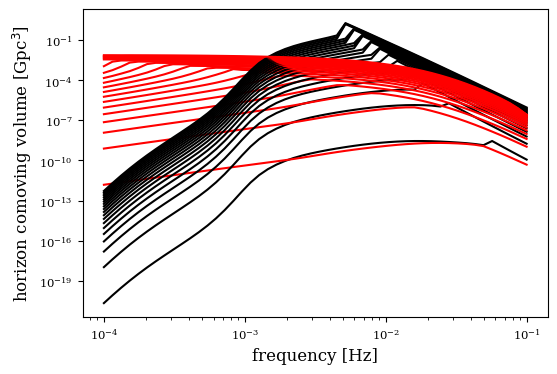

In [11]:
fig = plt.figure(figsize=(6,4))
for ii, mass1 in zip(range(0,len(m1)), m1):
    #plt.fill_between(f_LISA_grid.value, VH[4,ii,0,:].value, VH[4,ii,4,:].value, zorder=100-ii, label=f'm1={np.round(mass1, 2)}')
    plt.plot(f_LISA_grid.value, VH[4,ii,0,:].value, color='black')
    plt.plot(f_LISA_grid.value, VH[4,ii,5,:].value, color='red')
#plt.legend(loc='lower right')    
plt.xscale('log')
plt.yscale('log')

plt.xlabel('frequency [Hz]')
plt.ylabel('horizon comoving volume [Gpc$^3$]')

Text(0, 0.5, 'horizon comoving volume [Gpc$^3$]')

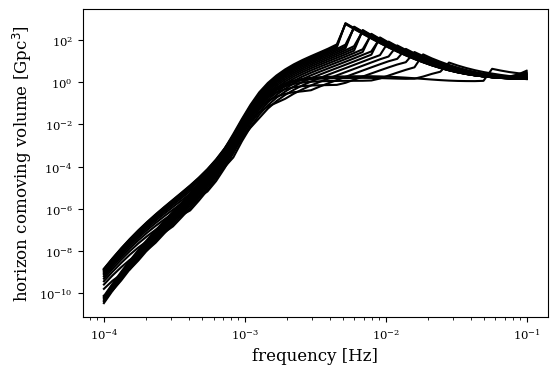

In [12]:
fig = plt.figure(figsize=(6,4))
for ii, mass1 in zip(range(0,len(m1)), m1):
    #plt.fill_between(f_LISA_grid.value, VH[4,ii,0,:].value, VH[4,ii,4,:].value, zorder=100-ii, label=f'm1={np.round(mass1, 2)}')
    plt.plot(f_LISA_grid.value, VH[4,ii,0,:].value / VH[4,ii,5,:].value, color='black')
#plt.legend(loc='lower right')    
plt.xscale('log')
plt.yscale('log')

plt.xlabel('frequency [Hz]')
plt.ylabel('horizon comoving volume [Gpc$^3$]')

In [13]:
VH_MAX = np.zeros((len(m1), len(ecc_LIGO_grid)))
for ii, mass1 in zip(range(0,len(m1)), m1):
    for ee, ecc in zip(range(len(ecc_LIGO_grid)), ecc_LIGO_grid):
        VH_MAX[ii,ee] = np.max(VH[:,ii,ee,:].value)
TMERGE_MAX = np.zeros((len(m1), len(ecc_LIGO_grid)))
for ii, mass1 in zip(range(0,len(m1)), m1):
    for ee, ecc in zip(range(len(ecc_LIGO_grid)), ecc_LIGO_grid):
        TMERGE_MAX[ii,ee] = np.max(TT_LIGO[:,ii,ee,:].value)
    
TMERGE_MAX = np.array(TMERGE_MAX)*u.yr
VH_MAX = np.array(VH_MAX)*u.Gpc**3    

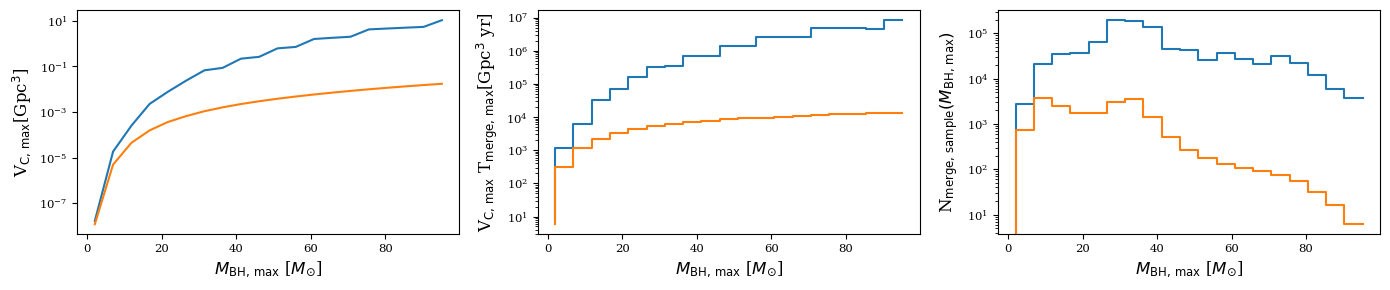

In [14]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.plot(m1, VH_MAX[:,0])
ax1.plot(m1, VH_MAX[:,5])
ax1.set_ylabel(r'V$_{\rm{C,\,max}}$[Gpc$^3$]')
ax2.plot(m1, VH_MAX[:,0]*TMERGE_MAX[:,0], drawstyle='steps')
ax2.plot(m1, VH_MAX[:,5]*TMERGE_MAX[:,5], drawstyle='steps')
ax2.set_ylabel(r'V$_{\rm{C,\,max}}$ T$_{\rm{merge,\,max}}$[Gpc$^3$ yr]')
ax3.plot(m1, VH_MAX[:,0]*TMERGE_MAX[:,0]*trapezoid(dN_dm1dqdVcdt, q, axis=0) * dm1, drawstyle='steps')
ax3.plot(m1, VH_MAX[:,5]*TMERGE_MAX[:,5]*trapezoid(dN_dm1dqdVcdt, q, axis=0) * dm1, drawstyle='steps')
ax3.set_ylabel(r'N$_{\rm{merge,\,sample}}(M_{\rm{BH,\,max}})$')
for ax in (ax1, ax2, ax3):
    ax.set_xlabel(r'$M_{\rm{BH,\,max}}$ [$M_{\odot}$]')
    ax.set_yscale('log')
plt.tight_layout()

In [15]:
VH_MAX_grid = np.zeros((len(m1), len(q), len(ecc_LIGO_grid)))
for ii, mass1 in zip(range(len(m1)), m1):
    for jj, mass_ratio in zip(range(len(q)), q):
        for ee, e in zip(range(len(ecc_LIGO_grid)), ecc_LIGO_grid):
            VH_MAX_grid[ii, jj, ee] = np.max(VH[jj,ii,ee,:].value)
        
DH_MAX_grid = np.zeros((len(m1), len(q), len(ecc_LIGO_grid)))
for ii, mass1 in zip(range(len(m1)), m1):
    for jj, mass_ratio in zip(range(len(q)), q):
        for ee, e in zip(range(len(ecc_LIGO_grid)), ecc_LIGO_grid):
            DH_MAX_grid[ii, jj] = np.max(DH[jj,ii,ee,:].value)
                       
TMERGE_MAX_grid = np.zeros((len(m1), len(q), len(ecc_LIGO_grid)))
for ii, mass1 in zip(range(len(m1)), m1):
    for jj, mass_ratio in zip(range(len(q)), q):
        for ee, e in zip(range(len(ecc_LIGO_grid)), ecc_LIGO_grid):
            TMERGE_MAX_grid[ii, jj] = np.max(TT_LIGO[jj,ii,ee,:].value)
    
TMERGE_MAX_grid = np.array(TMERGE_MAX_grid)*u.yr
VH_MAX_grid = np.array(VH_MAX_grid)*u.Gpc**3 
DH_MAX_grid = np.array(DH_MAX_grid)*u.Gpc

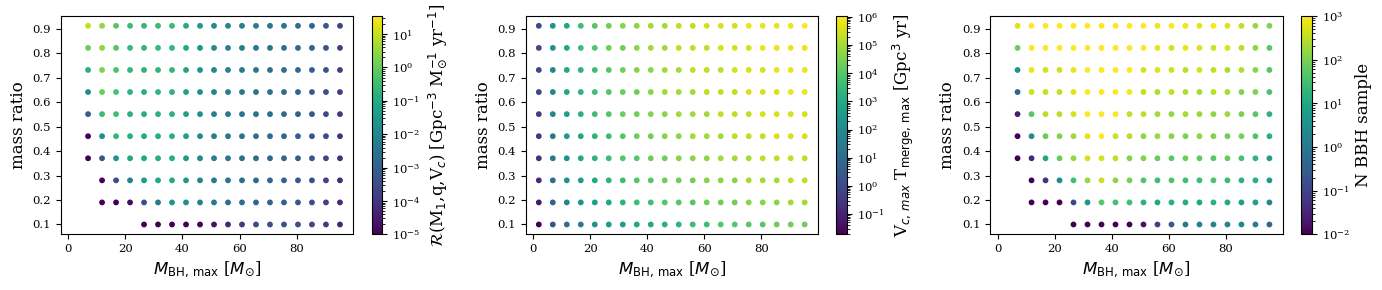

In [16]:
from matplotlib import colors
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

a1 = ax1.scatter(M1.value, Q, c=dN_dm1dqdVcdt.value, norm=colors.LogNorm(vmin=1e-5, vmax=35), s=10)
plt.colorbar(a1, label=r'$\mathcal{R}$(M$_1$,q,V$_c$) [Gpc$^{-3}$ M$_{\odot}^{-1}$ yr$^{-1}$]')
a2 = ax2.scatter(M1.value, Q, c=VH_MAX_grid[:,:,0].T.value*TMERGE_MAX_grid[:,:,0].T.value, norm=colors.LogNorm(), s=10)
plt.colorbar(a2, label=r'V$_{c,\,max}$ T$_{\rm{merge,\,max}}$ [Gpc$^3$ yr]')
a3 = ax3.scatter(M1.value, Q, c=VH_MAX_grid[:,:,0].T*TMERGE_MAX_grid[:,:,0].T*dN_dm1dqdVcdt * dm1 * dq, norm=colors.LogNorm(vmin=0.01, vmax=1000), s=10)
plt.colorbar(a3, label=r'N BBH sample')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel(r'$M_{\rm{BH,\,max}}$ [$M_{\odot}$]')
    ax.set_ylabel('mass ratio')
plt.tight_layout()

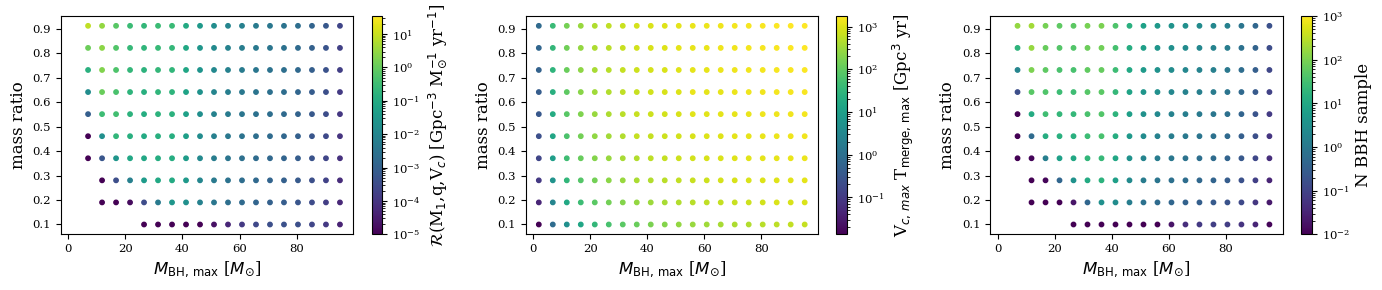

In [17]:
from matplotlib import colors
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

a1 = ax1.scatter(M1.value, Q, c=dN_dm1dqdVcdt.value, norm=colors.LogNorm(vmin=1e-5, vmax=35), s=10)
plt.colorbar(a1, label=r'$\mathcal{R}$(M$_1$,q,V$_c$) [Gpc$^{-3}$ M$_{\odot}^{-1}$ yr$^{-1}$]')
a2 = ax2.scatter(M1.value, Q, c=VH_MAX_grid[:,:,5].T.value*TMERGE_MAX_grid[:,:,5].T.value, norm=colors.LogNorm(), s=10)
plt.colorbar(a2, label=r'V$_{c,\,max}$ T$_{\rm{merge,\,max}}$ [Gpc$^3$ yr]')
a3 = ax3.scatter(M1.value, Q, c=VH_MAX_grid[:,:,5].T*TMERGE_MAX_grid[:,:,5].T*dN_dm1dqdVcdt * dm1 * dq, norm=colors.LogNorm(vmin=0.01, vmax=1000), s=10)
plt.colorbar(a3, label=r'N BBH sample')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel(r'$M_{\rm{BH,\,max}}$ [$M_{\odot}$]')
    ax.set_ylabel('mass ratio')
plt.tight_layout()

In [19]:
def get_f_LISA_e_LISA(dat_in):
    f_LIGO, e_LIGO, t_evol, m_1, m_2 = dat_in
    np.random.seed()
    if e_LIGO > 0:
        e_LISA_lo = utils.get_e_LISA(e_LIGO=e_LIGO, f_LISA=8e-5*u.Hz, m1=m_1, m2=m_2)
        t_merge = utils.get_T_LIGO(e_LISA=e_LISA_lo, f_LISA=8e-5*u.Hz, m1=m_1, m2=m_2).to(u.yr)
        if t_merge < t_evol.to(u.yr):
            return 1e-7, 0, t_merge
        
        else:
            e_grid_steps=10000
            a_LIGO = lw.utils.get_a_from_f_orb(f_orb=10 * u.Hz, m_1=m_1, m_2=m_2) 
            e_evol_grid = np.logspace(np.log10(e_LIGO), np.log10(e_LISA_lo), e_grid_steps)
            a_evol_grid = lw.utils.get_a_from_ecc(e_evol_grid, lw.utils.c_0(a_i=a_LIGO, ecc_i=e_LIGO)).to(u.Rsun)
            f_evol_grid = lw.utils.get_f_orb_from_a(a=a_evol_grid, m_1=m_1, m_2=m_2) 
            beta = lw.utils.beta(m_1, m_2)
            Tc = a_evol_grid**4 / (4 * beta)
            ecc_fac = (1 - e_evol_grid**2)**(7/2) * (1 + 0.27 * e_evol_grid**10 + 0.33 * e_evol_grid**20 + 0.2 * e_evol_grid**1000)
            T_merge = (Tc * ecc_fac).to(u.yr)
            if t_evol.to(u.yr) > np.max(T_merge):
                return 0.9e-4, 0, t_merge
            log_f_interp = interp1d(np.log10(T_merge.to(u.yr).value), np.log10(f_evol_grid.value))
            log_e_interp = interp1d(np.log10(T_merge.to(u.yr).value), np.log10(e_evol_grid))
            
            return 10**log_f_interp(np.log10(t_evol.to(u.yr).value)), 10**log_e_interp(np.log10(t_evol.to(u.yr).value)), t_merge
            
    else:
        e_LISA = 0.0
        f_LISA = lw.evol.evol_circ(
            m_1=m_1, m_2=m_2, f_orb_i=f_LIGO, t_evol=-t_evol, n_step=2,
            output_vars=["f_orb"])
        f_LISA = f_LISA[1].value
        
        return f_LISA, e_LISA, 1e7*u.yr

In [20]:
np.shape(M1), np.shape(Q), np.shape(TMERGE_MAX_grid)

((10, 20), (10, 20), (20, 10, 6))

In [94]:
def get_lisa_binaries(dat_in):
    m1, q, e_LIGO, T_merge_max, Dh_max, n_samp = dat_in
    n_int = int(n_samp)
    n_rem = n_samp % 1
    if np.random.uniform(0,1) < n_rem:
        n_int += 1
            
    if n_int > 0: 
        if T_merge_max.value > 0.0:
            T_merge = np.random.uniform(0, T_merge_max.value, n_int) * u.yr
            D_samp = np.random.uniform(0, Dh_max.value, n_int)
            D = (D_samp)**(1/3) * u.Gpc
            M1 = np.random.uniform((m1-dm1).value, (m1+dm1).value, n_int)
            Q = np.random.uniform(q-dq, q+dq, n_int)
            M2 = M1*Q
            dat_in = []
            for kk in range(n_int):
                dat_in.append([f_LIGO, e_LIGO, T_merge[kk], M1[kk]*u.Msun, M2[kk]*u.Msun])
                
                
            dat_out = []
            for d in dat_in:
                dat_out.append(get_f_LISA_e_LISA(d))
                
            f_LISA, e_LISA, t_LISA = zip(*dat_out)
                    
            f_LISA = np.array(f_LISA)*u.Hz
            e_LISA = np.array(e_LISA)
            
            
            LISA_mask = f_LISA > 1e-4 * u.Hz
            snr_list = []
            if sum(LISA_mask) > 0:
                return M1[LISA_mask], M2[LISA_mask], f_LISA[LISA_mask].value, e_LISA[LISA_mask], D[LISA_mask].value
            else:
                return [], [], [], [], []
                

In [95]:
def flatten_comprehension(matrix):
     return [item for row in matrix for item in row]

In [96]:
np.sum(dN_dm1dqdVcdt*dm1*dq)

<Quantity 12.34921378 1 / (yr Gpc3)>

In [97]:
trapezoid(trapezoid(dN_dm1dqdVcdt, m1, axis=1), q)

<Quantity 9.36646014 1 / (yr Gpc3)>

In [100]:
f_LIGO = 10*u.Hz

dat_MC = []
dat_ecc = []
for ii in tqdm.tqdm(range(50)):

    
    m1_list = []
    m2_list = []
    f_list = []
    ecc_list = []
    dist_list = []
    
    for ee, e_LIGO in enumerate(ecc_LIGO_grid):
        m1s = []
        m2s = []
        f_LISAs = []
        eccs = []
        dists = []
        snrs = []
        dat_in = []
        
        N_samp = VH_MAX_grid[:,:,ee]*TMERGE_MAX_grid[:,:,ee]*dN_dm1dqdVcdt.T * dm1 * dq

        for ii in range(len(m1)):
            for jj in range(len(q)):
                if N_samp[ii, jj].value > 0:
                    dat_in.append([M1[jj,ii], Q[jj,ii], e_LIGO, TMERGE_MAX_grid[ii, jj, ee], DH_MAX_grid[ii, jj, ee], N_samp[ii, jj].value])
        print(len(dat_in))    
        with MultiPool(processes=100) as pool:
            dat_out = tqdm.tqdm(list(pool.imap(get_lisa_binaries, dat_in)), total=len(dat_in))
        dat_list = []
        for d in dat_out:
            if d is not None:
                dat_list.append(d)
        
        m1s, m2s, f_LISAs, eccs, dists = zip(*dat_list)            
        m1s = flatten_comprehension(m1s)
        m2s = flatten_comprehension(m2s)
        f_LISAs = flatten_comprehension(f_LISAs)
        eccs = flatten_comprehension(eccs)
        dists = flatten_comprehension(dists)
        
        #s = lw.source.Source(m_1 = m1s*u.Msun,
        #                     m_2 = m2s*u.Msun,
        #                     ecc = eccs,
        #                     f_orb=f_LISAs*u.Hz,
        #                     dist=dists * u.Gpc,
        #                     interpolate_g=False,
        #                     gw_lum_tol=0.05,
        #                     n_proc=128)
        #snr = s.get_snr(t_obs=6*u.yr, verbose=True)
        #print(f'The number of SNR > 7 systems is {len(snr[snr>7])}')
        m1_list.append(m1s)
        m2_list.append(m2s)
        f_list.append(f_LISAs)
        ecc_list.append(eccs)
        dist_list.append(dists)          
    dat_ecc.append([m1_list, m2_list, f_list, ecc_list, dist_list])
    

  0%|          | 0/50 [00:00<?, ?it/s]

184



100%|██████████| 184/184 [00:00<00:00, 622.41it/s]

is this the think that takes a long time?
184




100%|██████████| 184/184 [00:00<00:00, 662.41it/s]

is this the think that takes a long time?
184




100%|██████████| 184/184 [00:00<00:00, 678.22it/s]

is this the think that takes a long time?
184




100%|██████████| 184/184 [00:00<00:00, 808.23it/s]

is this the think that takes a long time?
184




100%|██████████| 184/184 [00:00<00:00, 741.34it/s]

is this the think that takes a long time?
184




  2%|▏         | 1/50 [02:02<1:40:06, 122.58s/it]

is this the think that takes a long time?
184


  2%|▏         | 1/50 [02:11<1:47:17, 131.37s/it]


KeyboardInterrupt: 

In [25]:
import cmasher as cmr

cs = cmr.take_cmap_colors('cmr.guppy', len(ecc_LIGO_grid), cmap_range=(0.05, 0.9), return_fmt='hex')

[[], [], [], [], [], []]
6
(82163, 6) (1, 6)
(82154, 6) (0, 6)
(75080, 6) (0, 6)
(2623, 6) (1, 6)
(34, 6) (0, 6)
(0, 6) (0, 6)
(82185, 6) (1, 6)
(82157, 6) (1, 6)
(75132, 6) (0, 6)
(2634, 6) (0, 6)
(32, 6) (0, 6)
(0, 6) (0, 6)
(82181, 6) (1, 6)
(82156, 6) (1, 6)
(75135, 6) (1, 6)
(2623, 6) (0, 6)
(32, 6) (0, 6)
(0, 6) (0, 6)
(82177, 6) (0, 6)
(82167, 6) (2, 6)
(75225, 6) (1, 6)
(2614, 6) (0, 6)
(30, 6) (0, 6)
(0, 6) (0, 6)
(82197, 6) (1, 6)
(82147, 6) (0, 6)
(75129, 6) (1, 6)
(2646, 6) (1, 6)
(29, 6) (0, 6)
(0, 6) (0, 6)


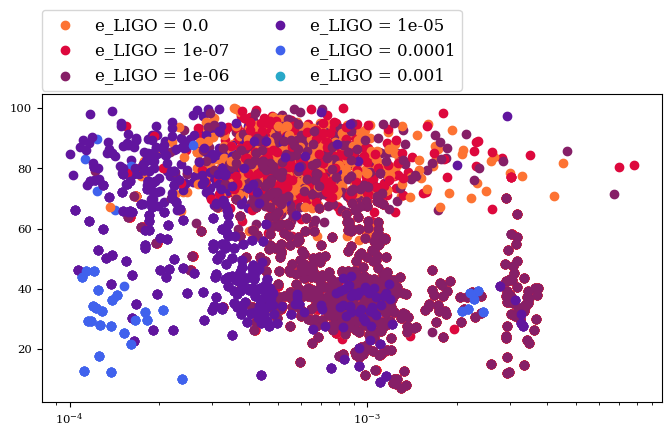

In [63]:
snr_thresh = 0.1
e_LIGO = ecc_LIGO_grid
jj=0
fig = plt.figure(figsize=(8,4))
m1 = [[], [], [], [], [], []]
forb = [[], [], [], [], [], []]
print(m1)
print(len(m1))
for dat_ecc in dat_MC:
    for ii,d in enumerate(dat_ecc):
        if jj == 0:
            plt.scatter(d[d[:,5]>snr_thresh][:,2], d[d[:,5]>snr_thresh][:,0], label=f'e_LIGO = {e_LIGO[ii]}', c=cs[ii])
        else:
            plt.scatter(d[d[:,5]>snr_thresh][:,2], d[d[:,5]>snr_thresh][:,0], c=cs[ii])
        print(np.shape(d), d[d[:,5]>12].shape)
        m1[ii].extend(d[d[:,5]>snr_thresh][:,0])
        forb[ii].extend(d[d[:,5]>snr_thresh][:,2])
    plt.xscale('log')
    #plt.yscale('log')
    if jj == 0:
        plt.legend(loc=(0,1.01), ncol=2)
    jj+=1
plt.show()

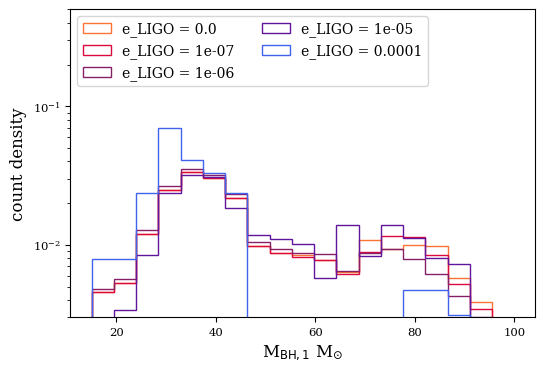

In [66]:
fig = plt.figure(figsize=(6,4))
for ii, m in enumerate(m1):
    if len(m) > 0:
        plt.hist(m, bins=np.linspace(15, 100, 20), histtype='step', color=cs[ii], label=f'e_LIGO = {e_LIGO[ii]}', density=True)
plt.yscale('log')
plt.ylim(3e-3, 0.5)
plt.xlabel(r'M$_{\rm{BH},1}$ M$_{\odot}$')
plt.ylabel('count density')
plt.legend(ncol=2, loc='upper left', prop={'size':10})


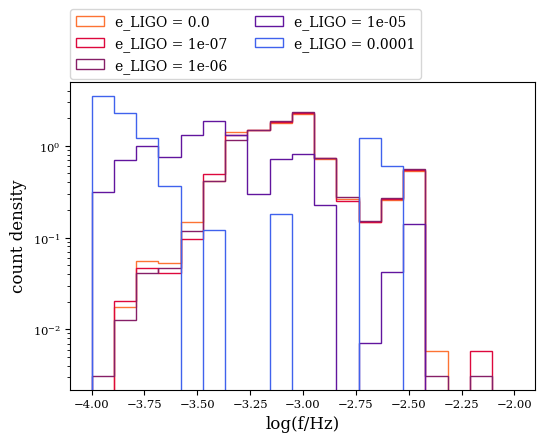

In [68]:
fig = plt.figure(figsize=(6,4))
for ii, m in enumerate(forb):
    if len(m) > 0:
        plt.hist(np.log10(m), bins=np.linspace(-4, -2, 20), histtype='step', color=cs[ii], label=f'e_LIGO = {e_LIGO[ii]}', density=True)
plt.yscale('log')
#plt.ylim(3e-3, 0.5)
plt.xlabel(r'log(f/Hz)')
plt.ylabel('count density')
plt.legend(ncol=2, loc=(0,1.01), prop={'size':10})


In [ ]:
plt.figure(figsize=(6,4))
for ii in range(0,len(q),3):
    plt.plot(m1, VH_MAX_grid[:,ii])
plt.yscale('log')

In [ ]:
plt.plot(m1, VH_MAX*TMERGE_MAX*trapezoid(dN_dm1dqdVcdt, q, axis=0), drawstyle='steps')
plt.yscale('log')

In [ ]:
for ii, mass1 in zip(range(0,len(m1),3), m1[::3]):
    plt.fill_between(f_LISA_grid.value, 
                     VH[4,ii,0,:].value*TT_LIGO[4,ii,0,:].value, 
                     VH[4,ii,9,:].value*TT_LIGO[4,ii,9,:].value, zorder=100-ii, label=f'm1={np.round(mass1.value, 2)} Msun')
plt.legend(loc='upper right', prop={'size':14})    
plt.xscale('log')
plt.yscale('log')

plt.xlabel('frequency [Hz]', size=14)
plt.ylabel(r'horizon comoving volume $\times$ merger time [Gpc$^3$ yr]', size=14)

In [ ]:
np.shape(dN_dm1dqdVcdt)

In [ ]:
for ii, mass1 in zip(range(0,len(m1),3), m1[::3]):
    plt.fill_between(f_LISA_grid.value, 
                     (VH[2,ii,0,:]*TT_LIGO[2,ii,0,:]*dN_dm1dqdVcdt[4,ii]).value, 
                     (VH[2,ii,9,:]*TT_LIGO[2,ii,9,:]*dN_dm1dqdVcdt[4,ii]).value, 
                     zorder=ii, label=f'm1={np.round(mass1.value, 2)} Msun')
    
    print(dN_dm1dqdVcdt[2,ii])
plt.legend(loc='upper right', prop={'size':14})    
plt.xscale('log')
plt.yscale('log')

plt.xlabel('frequency [Hz]', size=14)
plt.ylabel(r'horizon comoving volume $\times$ merger time [Gpc$^3$ yr]', size=14)

In [ ]:
from matplotlib import colors

In [ ]:
print(np.shape(MM), np.shape(VH[:,:,0,0]))

plt.scatter(MM[:,:,9,0], QQ[:,:,9,0], c=(VH[:,:,9,0]*TT_LIGO[:,:,9,0]*dN_dm1dqdVcdt[:,:]).value, norm=colors.LogNorm())
plt.colorbar()

In [ ]:
VH[:,:,0,0]*TT_LIGO[:,:,0,0]*dN_dm1dqdVcdt[:,:]
print(np.shape(MM))

In [ ]:
VH[:,:,0,0]*TT_LIGO[:,:,0,0]*dN_dm1dqdVcdt[:,:]*MM[:,:,0,0]*QQ[:,:,0,0]

In [ ]:
VH[:,:,9,0]*TT_LIGO[:,:,9,0]*dN_dm1dqdVcdt[:,:]*MM[:,:,9,0]*QQ[:,:,9,0]